# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

In [4]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra

In [17]:
include("../src/testfns.jl")

get_random_testfn (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

Test Function: BukinN6


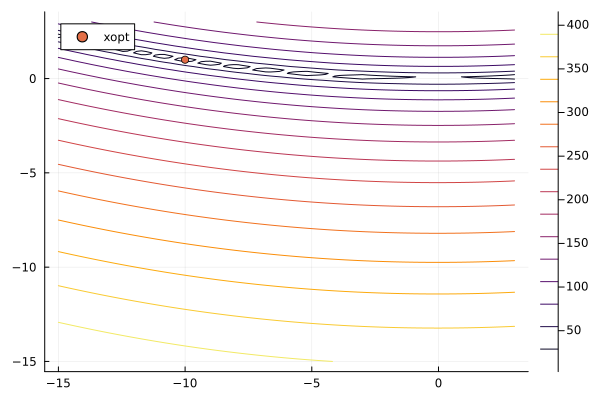

In [18]:
testfn, testfn_name = get_random_testfn()
println("Test Function: $(testfn_name)")
tplot(testfn)